# Project \#4: Find the “Largest” Digit

# Part 3 : Kaggle Submission

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing

import keras.models
import keras.layers
import keras.optimizers
import keras.preprocessing
import keras.callbacks

Using Theano backend.


## Read and Preprocess the Data

In [2]:
!ls

0_DataPreprocessing.ipynb  3_KaggleSubmission.ipynb  Datasets  notebook.ipynb


sample_x.csv  sample_y.csv  train_x.csv  train_y.csv


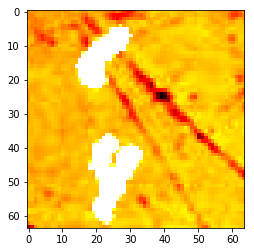

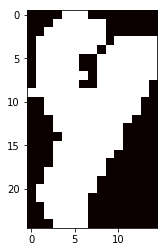

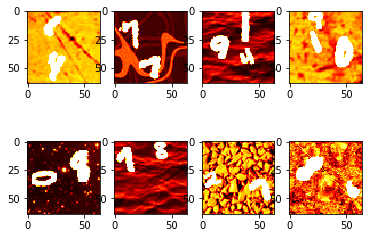

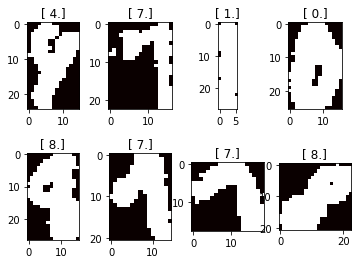

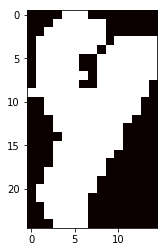

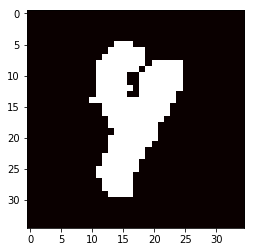

(15, 15)


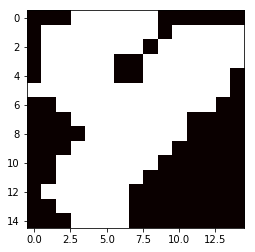

(40, 40)


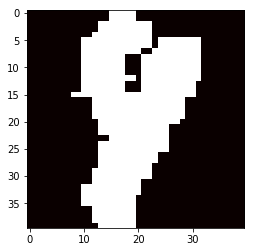

In [3]:
%run 0_DataPreprocessing.ipynb

In [4]:
!ls ./Datasets

sample_x.csv  sample_y.csv  train_x.csv  train_y.csv


In [5]:
!head -n 100 Datasets/train_x.csv > Datasets/sample_x.csv
!head -n 100 Datasets/train_y.csv > Datasets/sample_y.csv

In [6]:
TARGET_SHAPE = (25,25)

In [7]:
processedData = readAndPreprocess('./Datasets/sample_x.csv', TARGET_SHAPE)

In [8]:
y = np.loadtxt("Datasets/sample_y.csv", delimiter=",").reshape(-1, 1)

In [9]:
processedData = processedData.reshape(-1, TARGET_SHAPE[0], TARGET_SHAPE[1], 1)

In [10]:
y = sklearn.preprocessing.OneHotEncoder().fit_transform(y).toarray()

## Define the Model

In [11]:
from keras import backend as K
#refer to : https://github.com/keras-team/keras/issues/2681#issuecomment-257157218
K.set_image_dim_ordering('tf')

In [13]:
model = keras.models.Sequential()

input_shape=(TARGET_SHAPE[0],TARGET_SHAPE[1], 1)
model.add(keras.layers.Conv2D(32, nb_row=5, nb_col=5, border_mode='same', activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(32, nb_row=5, nb_col=5, border_mode='same', activation ='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))


model.add(keras.layers.Conv2D(64, nb_row=3, nb_col=3, border_mode='same', activation='relu'))
model.add(keras.layers.Conv2D(64, nb_row=3, nb_col=3, border_mode='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(keras.layers.Dropout(0.25))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation = "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation = "softmax"))

/home/angus/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/angus/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/angus/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [14]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
epochs = 10
batch_size = 86

In [16]:
X_train = processedData[len(processedData)/5:]
Y_train = y[len(processedData)/5:]
X_val = processedData[:len(processedData)/5]
Y_val = y[:len(processedData)/5]

In [17]:
print 'X_train', X_train.shape
print 'Y_train', Y_train.shape
print 'X_val', X_val.shape
print 'Y_val', Y_val.shape

X_train (80, 25, 25, 1)
Y_train (80, 10)
X_val (20, 25, 25, 1)
Y_val (20, 10)


In [18]:
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=epochs, validation_data = (X_val, Y_val), verbose=2)

Train on 80 samples, validate on 20 samples
Epoch 1/10
0s - loss: 2.3031 - acc: 0.0500 - val_loss: 2.2572 - val_acc: 0.0000e+00
Epoch 2/10
0s - loss: 2.2532 - acc: 0.2250 - val_loss: 3.7067 - val_acc: 0.0500
Epoch 3/10
0s - loss: 4.4355 - acc: 0.2000 - val_loss: 2.2310 - val_acc: 0.2000
Epoch 4/10
0s - loss: 2.3062 - acc: 0.1000 - val_loss: 2.2822 - val_acc: 0.3500
Epoch 5/10
0s - loss: 2.2993 - acc: 0.1250 - val_loss: 2.2569 - val_acc: 0.2500
Epoch 6/10
0s - loss: 2.2904 - acc: 0.1750 - val_loss: 2.2281 - val_acc: 0.2000
Epoch 7/10
0s - loss: 2.2862 - acc: 0.1375 - val_loss: 2.2674 - val_acc: 0.0000e+00
Epoch 8/10
0s - loss: 2.2664 - acc: 0.1875 - val_loss: 2.1352 - val_acc: 0.2500
Epoch 9/10
0s - loss: 2.2442 - acc: 0.1000 - val_loss: 2.1729 - val_acc: 0.2500
Epoch 10/10
0s - loss: 2.2104 - acc: 0.2125 - val_loss: 2.1472 - val_acc: 0.0500
